In [1]:
import sys 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')
import json

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
import seaborn as sns
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
from get_brian_rna import *

In [5]:
from upsetplot import generate_counts
from upsetplot import plot
from matplotlib import pyplot

## Collect phenotype IDs

Our goal was to collect central phenotypes that shape the tumor immune microenvironment. These phenotypes include measures of immune states, immune infiltration and gene expression collected from a variety of sources, including gene sets, literature, and results of tool calculations

In [6]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])
        

In [7]:
antigen_present=pd.read_csv("../downloaded_phenos/antigen_present_geneset.txt",skiprows=[1])
antigen_present_list=antigen_present["GO_ANTIGEN_PROCESSING_AND_PRESENTATION"].tolist()
antigen_present_list.append("MARCH1")

In [8]:
im_landscape=pd.read_csv("../downloaded_phenos/im-landscape-markers.txt",header=None)
im_landscape_list=im_landscape[0].tolist()

In [9]:
danaher=pd.read_csv("../downloaded_phenos/danaher_markers.csv")
danaher_list=danaher["Gene"].tolist()

In [10]:
im_checkpoint=pd.read_csv("../downloaded_phenos/immune-checkpoint.csv")
im_checkpoint_list=im_checkpoint["HGNC Symbol"].tolist()
im_checkpoint_list=[x for x in im_checkpoint_list if str(x) != "nan"]

In [11]:
landscape=pd.read_csv("../downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape_comps=landscape.columns[2:]

In [12]:
landscape_comps

Index(['Proliferation', 'Wound.Healing', 'Macrophage.Regulation',
       'Lymphocyte.Infiltration.Signature.Score', 'IFN.gamma.Response',
       'TGF.beta.Response'],
      dtype='object')

In [13]:
ifng=pd.read_csv("../downloaded_phenos/ifng-markers.txt",header=None)
ifng_list=ifng[0].tolist()

In [14]:
tgfbeta=pd.read_csv("../downloaded_phenos/tgf-beta-markers.txt",header=None)
tgfbeta_list=tgfbeta[0].tolist()

In [15]:
cibersortx=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx_compiled_allsig.tsv",delimiter="\t")
cibersortx_list=[x.replace(" ",".") for x in cibersortx.columns[1:]]

In [16]:
print(len(antigen_present_list))
print(len(im_landscape_list))
print(len(danaher_list))
print(len(im_checkpoint_list))
print(len(landscape_comps))
print(len(ifng_list))
print(len(tgfbeta_list))
print(len(cibersortx_list))


228
436
60
78
6
6
19
61


### Create phenotype dictionary

In [17]:
pheno_dict={}

for x in antigen_present_list:
    x=x.replace("-",".")
    pheno_dict[x]="antigen present"
for x in im_landscape_list:
    x=x.replace("-",".")
    pheno_dict[x]="immunomodulators"
for x in danaher_list:
    x=x.replace("-",".")
    pheno_dict[x]="cell type"
for x in im_checkpoint_list:
    x=x.replace("-",".")
    pheno_dict[x]="immune checkpoint"
for x in landscape_comps:
    x=x.replace("-",".")
    pheno_dict[x]="landscape components"
for x in ifng_list:
    x=x.replace("-",".")
    pheno_dict[x]="IFNG"    
for x in tgfbeta_list:
    x=x.replace("-",".")
    pheno_dict[x]="TGFbeta"
for x in cibersortx_list:
    x=x.replace("-",".")
    pheno_dict[x]="immune infiltration"

In [18]:
for x in pheno_dict.keys():
    if "HLA" in x:
        pheno_dict[x]="antigen present"

In [19]:
print(len(pheno_dict))

833


In [20]:
import json
with open('pheno_dictionary.json', 'w') as json_file:
    json.dump(pheno_dict, json_file)

In [21]:
with open('pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)

In [22]:
pheno_dict["BRCA2"]

'immunomodulators'

In [23]:
pheno_map=pd.DataFrame(pheno_dict,index=[0])

In [24]:
pheno_map=pheno_map.T

In [25]:
pheno_map.to_csv("phenotype.mapping.csv",header=None)

## Make phenotype file for PLINK

### Collect RNA phenotypes from TPM data

In [26]:
def brian_tpm_filter(lst):
    #load brian's rna dataframe
    colnames = np.loadtxt('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.columns.txt', dtype=str)
    rownames = np.loadtxt('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.index.txt', dtype=str)
    tcga_df = pd.DataFrame(np.load('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.npy'), index=rownames, columns=colnames)

    #get legacy mapping data
    legacy_df = pd.read_csv('/cellar/users/andreabc/Data/GDC_barcodes/LEGACY_uuid_barcode_map.txt', 
                        sep='\t', index_col='submitter_uuid')
    legacy_df = legacy_df.reset_index()
    legacy_df = legacy_df[legacy_df.submitter_uuid.notnull()] #get rid of null submitter uuid
    
    #filter dataframe for genes in list
    filt = tcga_df.loc[tcga_df.index.isin(lst),:]
    filt =  filt.T
    
    #map ids to TCGA barcode
    dic = dict(zip(legacy_df.submitter_uuid, legacy_df.sample_barcode))
    filt.index=filt.index.map(dic)
    filt=filt[filt.index.notnull()]

    return(filt)

In [27]:
all_pheno=antigen_present_list+im_landscape_list+danaher_list+im_checkpoint_list+ifng_list+tgfbeta_list
rna=brian_tpm_filter(all_pheno)

In [28]:
rna.head()

,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,TNFRSF12A,...,PSMB3,NCF4,LILRB2,KIR3DL2,PDCD1,HLA-DRA,KIR2DL2,LAIR1,FCAR,KIR2DL1
TCGA-ZA-A8F6-01A,17.131453,7.566690,4.347806,480.936279,33.470673,8.454793,62.722713,58.418682,16.266356,62.108425,...,4.246390,1.784200,3.988425,0.00000,0.000000,0.43908,0.0,20.833727,0.007162,0.0
TCGA-BB-4223-01A,5.577954,86.989151,14.501068,576.514771,25.219648,20.179363,62.558010,48.558121,19.415529,20.282911,...,2.108560,1.004730,1.625378,0.03362,0.008088,28.93940,0.0,7.617002,0.000184,0.0
TCGA-G9-6348-11A,2.645121,16.762747,10.261188,98.547859,9.569573,15.200922,35.604427,32.050564,47.053909,24.141825,...,0.000000,0.174259,0.328162,0.00000,0.604971,13.50390,0.0,1.423922,0.363611,0.0
TCGA-R5-A7ZE-01B,0.762767,39.868507,37.553936,400.342499,10.433505,12.851951,58.131935,41.090664,2.107088,40.535870,...,0.619157,0.178445,0.130744,0.00000,0.000000,0.00000,0.0,0.215687,0.216500,0.0
TCGA-DD-A4NQ-01A,3.994697,2.809687,12.413517,298.211700,3.915368,12.721095,10.358677,19.138075,1.455972,101.450882,...,1.048170,0.207225,0.679936,0.00000,0.198545,0.00000,0.0,0.960103,0.000013,0.0


In [29]:
rna["code"]=rna.index.str.split("-").str[-1]
rna["barcode"]=rna.index.str[0:12]

In [30]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
rna["cancer"]=rna["barcode"].map(mp)

In [31]:
rna_tumor=rna[rna["code"].str.contains("01")]

In [32]:
rna_tumor["code"].value_counts()

01A    9503
01B     200
01C      10
Name: code, dtype: int64

In [33]:
#convert index to short barcodes
del rna_tumor["code"]
del rna_tumor["cancer"]
rna_tumor.index=rna_tumor["barcode"]
del rna_tumor["barcode"]

In [34]:
#take mean for individuals with multiple samples
rna=rna_tumor
rna=rna.groupby(rna.index).mean()

In [35]:
#filter out phenotypes with > 10% zero values
rna=filter_zeros(rna,0.1)

36 phenotypes with > 0.1 zeroes were removed


In [36]:
print(rna.shape)

(9561, 728)


In [37]:
rna=rna.reset_index().rename(columns={"barcode":"FID"}).set_index("FID")

### Collect CIBERSORTX data

In [40]:
ciber=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx_compiled_allsig.tsv",delimiter="\t")
ciber.columns=[x.replace(" ",".") for x in ciber.columns]
ciber=ciber.rename(columns={"Mixture":"FID"})
ciber=ciber.set_index("FID")

In [39]:
ciber=filter_zeros(ciber,0.1)

49 phenotypes with > 0.1 zeroes were removed


In [42]:
print(ciber.shape)

(9561, 61)


In [44]:
ciber=ciber.reset_index()

In [46]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
#total['cancer'] = total["FID"].map(mp)
ciber["cancer"]=ciber["FID"].map(mp)

In [47]:
for x in ciber["cancer"].unique():
    try:
        tumor=ciber[ciber["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/ciber/pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass

In [49]:
compiled=pd.DataFrame()
for x in ciber["cancer"].unique().tolist():
    try:
        df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/ciber/pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

In [51]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [53]:
compiled.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/ciber/pheno_all_zcancer",index=None,sep="\t")

### Collect Thorsson et al. immune state scores file

In [40]:
landscape=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape=landscape.replace(-9, np.nan)
del landscape["IID"]
landscape=landscape.set_index("FID")
landscape.head()

,Proliferation,Wound.Healing,Macrophage.Regulation,Lymphocyte.Infiltration.Signature.Score,IFN.gamma.Response,TGF.beta.Response
FID,,,,,,
TCGA-01-0639,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0007,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0011,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0023,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0025,NaN,NaN,NaN,NaN,NaN,NaN


### Combine all immune phenotypes

In [41]:
total=pd.merge(rna,landscape,on=["FID"],how="outer")
total=pd.merge(total, ciber,on=["FID"],how="outer")

In [42]:
total = total.apply(pd.to_numeric,errors="coerce")

In [43]:
print(total.shape)
total.head()

(11206, 746)


,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,TNFRSF12A,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
FID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,10.462351,11.120751,64.943344,222.796921,19.143368,32.310970,68.991638,160.023560,76.170135,84.221405,...,0.324123,0.687473,0.043183,0.443866,0.069350,0.161311,0.498600,0.247231,0.302062,0.320460
TCGA-02-0055,12.997394,3.542931,12.078923,340.213165,8.614352,39.206337,61.047665,45.648369,25.906631,264.725098,...,0.289852,0.488191,0.062705,0.361803,0.072963,0.187417,0.666249,0.005093,0.704929,0.232990
TCGA-02-2483,9.448974,6.983698,18.041054,338.070496,13.141633,46.284431,24.381243,84.151978,20.013517,40.882793,...,0.468067,0.634741,0.096529,0.326827,0.054753,0.158911,0.392754,0.284847,0.262851,0.330924
TCGA-02-2485,7.011187,3.265420,29.600166,360.969116,19.037817,42.300026,7.119283,91.086723,20.380697,80.461861,...,0.294261,0.910478,0.112156,0.225340,0.069608,0.136810,0.439758,0.503177,0.225134,0.212266
TCGA-02-2486,13.871422,2.507942,12.292249,229.997849,4.587289,45.148750,146.060394,63.454029,10.426679,135.188126,...,0.426537,0.715499,0.030492,0.351950,0.150781,0.364722,0.671309,0.080076,0.311433,0.413945


In [44]:
total[total.index.duplicated()]

,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,TNFRSF12A,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
FID,,,,,,,,,,,,,,,,,,,,,


### Filter for only genotyped patients

In [45]:
#get genotyped patients
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",header=None,sep=" ")[0].tolist()

In [46]:
tcga_df=total[total.index.isin(fam)]

In [47]:
tcga_df=tcga_df.reset_index()

In [48]:
tcga_df=tcga_df.rename(columns={"index":"FID"})

In [49]:
print(tcga_df.shape)
tcga_df.head()

(8207, 747)


,FID,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
0,TCGA-02-0047,10.462351,11.120751,64.943344,222.796921,19.143368,32.310970,68.991638,160.023560,76.170135,...,0.324123,0.687473,0.043183,0.443866,0.069350,0.161311,0.498600,0.247231,0.302062,0.320460
1,TCGA-02-0055,12.997394,3.542931,12.078923,340.213165,8.614352,39.206337,61.047665,45.648369,25.906631,...,0.289852,0.488191,0.062705,0.361803,0.072963,0.187417,0.666249,0.005093,0.704929,0.232990
2,TCGA-02-2486,13.871422,2.507942,12.292249,229.997849,4.587289,45.148750,146.060394,63.454029,10.426679,...,0.426537,0.715499,0.030492,0.351950,0.150781,0.364722,0.671309,0.080076,0.311433,0.413945
3,TCGA-04-1332,1.587327,18.889095,21.084179,72.480659,20.600607,10.533038,26.183832,12.907973,23.363880,...,0.212655,0.839303,0.035891,0.206038,0.196037,0.486295,0.777307,0.186912,0.752511,0.131154
4,TCGA-04-1338,2.084633,6.618918,10.275887,80.976318,8.162801,14.475409,47.023655,12.441605,6.865872,...,0.192444,0.642535,0.069717,0.228317,0.114303,0.388767,0.731318,0.063031,0.735070,0.240005


## Submit cancer-specific phenos for rank normalization

In [50]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
#total['cancer'] = total["FID"].map(mp)
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [51]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass
    
    

In [53]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm by cancer

Text(0.5, 1.0, 'FGR')

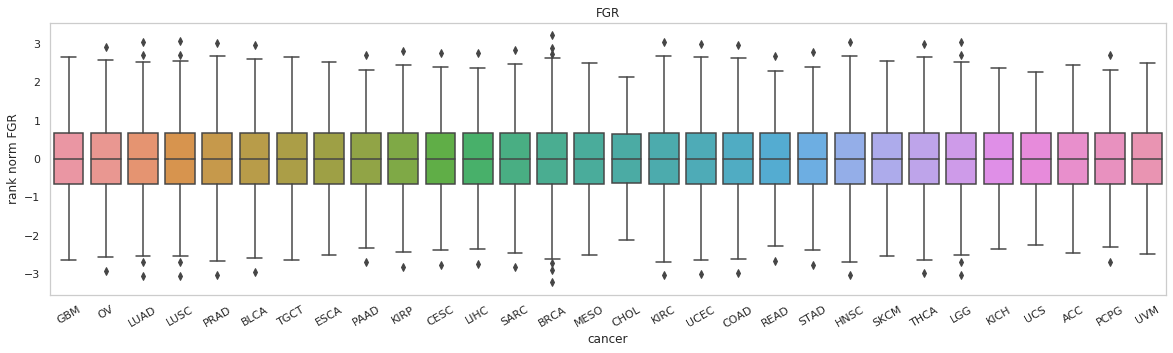

In [54]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [55]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [56]:
compiled.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/pheno_all_zcancer",index=None,sep="\t")

In [57]:
print(compiled.shape)
compiled.head()

(8207, 748)


,FID,IID,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
1,TCGA-02-0047,TCGA-02-0047,0.574582,0.995132,1.478237,-1.267664,0.809839,-0.838697,0.868271,2.043696,...,-0.674490,-0.367676,-0.175539,1.478237,-0.781640,-0.503299,0.030824,-0.259717,0.281029,0.503299
2,TCGA-02-0055,TCGA-02-0055,0.995132,-0.598989,-1.223048,0.281029,-0.674490,-0.217436,0.754049,-1.542505,...,-0.929830,-1.788034,0.345780,0.457181,-0.674490,-0.259717,1.694534,-2.643857,2.643857,-0.154711
3,TCGA-02-2486,TCGA-02-2486,1.180743,-0.898625,-1.140451,-1.101931,-1.542505,0.217436,1.900427,-0.700514,...,0.196444,-0.051388,-0.648915,0.345780,1.064979,0.781640,1.900427,-1.788034,0.367676,1.314956
4,TCGA-06-0129,TCGA-06-0129,1.419554,-1.900427,-1.613862,-0.574582,2.643857,2.247781,-1.542505,0.781640,...,2.247781,2.247781,-0.389750,0.868271,-1.967025,-2.400036,-2.643857,-0.868271,-2.643857,2.643857
5,TCGA-06-0130,TCGA-06-0130,1.694534,-0.503299,-0.929830,0.324048,-0.480112,-0.995132,-0.457181,-1.613862,...,0.550514,0.781640,-0.929830,0.324048,1.613862,0.898625,0.324048,-1.900427,1.788034,1.900427


In [58]:
compiled[compiled["FID"].duplicated()]

,FID,IID,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages


## Confirm phenotypes are normally distributed

In [54]:
pheno=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/pheno_all_zcancer",delimiter="\t")


## Pearson correlation of phenos

We wanted to determine whether our phenotypes were strongly correlated or anti-correlated with each other.

In [55]:
del pheno["IID"]

In [56]:
pheno=pheno.replace(-9, np.nan)

In [57]:
pheno_corr=pheno.corr(method="pearson")

In [58]:
pheno_corr.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/immune-phenotype-pearson/brian.tpm.immune.phenotypes.pearson.csv")